# Strojenie parametrów wyszukiwarki

Ten notebook służy do eksperymentowania z różnymi parametrami wyszukiwarki, takimi jak liczba wartości osobliwych (k) w SVD oraz wpływ IDF na wyniki wyszukiwania.

In [2]:
import os
import sys

sys.path.append('..')

import sqlite3

import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from src.preprocessing import (apply_idf, build_vocabulary,
                               create_document_vectors)
from src.search import query_to_vector, search_documents

In [3]:
# Konfiguracja
DB_PATH = os.path.join(
        os.path.dirname(os.path.dirname(os.path.abspath("__file__"))),
        "data",
        "simplified_wiki_index.db",
    )

In [4]:
# Budowanie słownika i macierzy term-document
vocabulary = build_vocabulary(DB_PATH)
term_doc_matrix, doc_ids = create_document_vectors(DB_PATH, vocabulary)

# Zastosuj IDF
tfidf_matrix, idf_values = apply_idf(term_doc_matrix)

normalized_matrix = normalize(term_doc_matrix, axis=1)

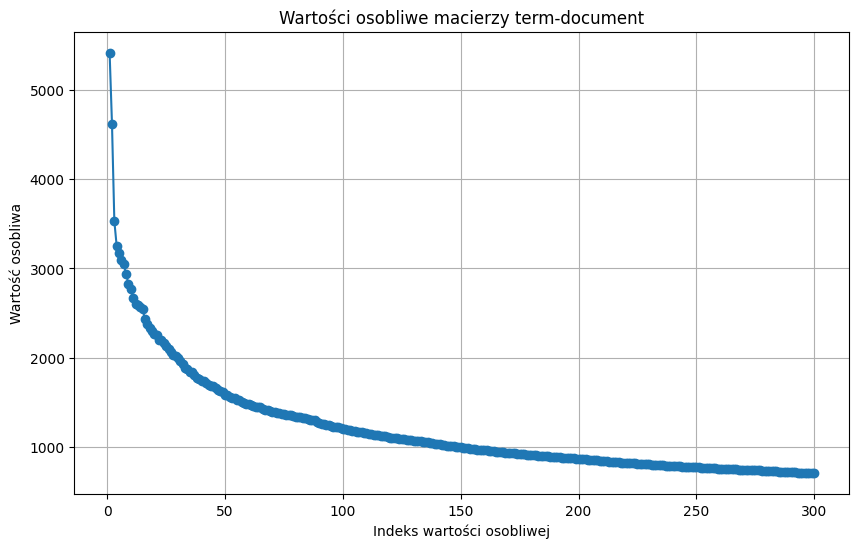

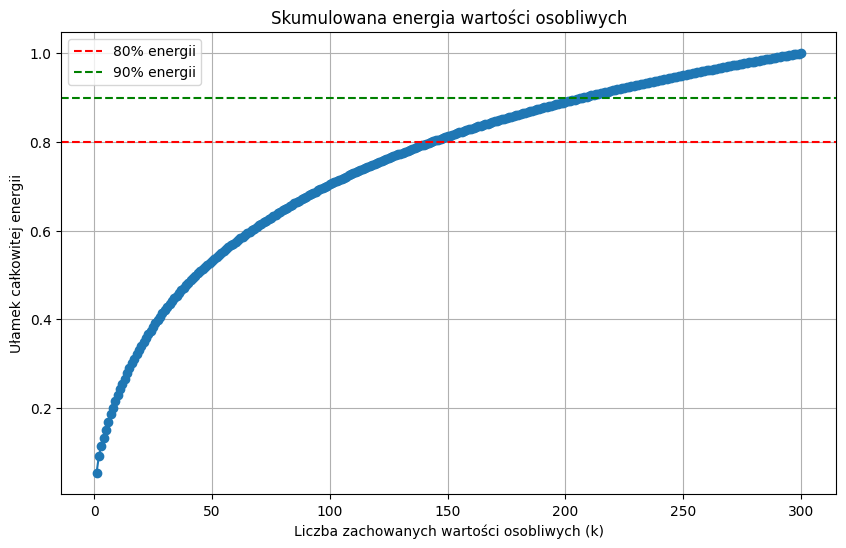

In [5]:
# Zbadaj wartości osobliwe
k_max = 300  # Maksymalna liczba wartości osobliwych do zbadania
U, D, V_T = svds(tfidf_matrix.tocsc(), k=k_max)

# Sortuj wartości osobliwe malejąco
idx = np.argsort(-D)
D_sorted = D[idx]

# Rysowanie wykresu wartości osobliwych
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, k_max+1), D_sorted, 'o-')
plt.title('Wartości osobliwe macierzy term-document')
plt.xlabel('Indeks wartości osobliwej')
plt.ylabel('Wartość osobliwa')
plt.grid(True)
plt.show()

# Rysowanie wykresu skumulowanej energii wartości osobliwych
cumulative_energy = np.cumsum(D_sorted**2) / np.sum(D_sorted**2)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, k_max+1), cumulative_energy, 'o-')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% energii')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% energii')
plt.title('Skumulowana energia wartości osobliwych')
plt.xlabel('Liczba zachowanych wartości osobliwych (k)')
plt.ylabel('Ułamek całkowitej energii')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Porównanie wyników wyszukiwania dla różnych wartości k
test_queries = [
    "artificial intelligence",
    "quantum physics",
    "history of Poland",
    "climate change",
    "machine learning algorithms"
]

k_values = [10, 50, 100, 200, 300]  # Różne wartości k dla SVD

# Słownik do przechowywania wyników
results_by_k = {}
for k_svd in k_values:
    results_for_k = {}
    # approx_matrix, U_k, D_k, V_T_k = apply_svd(tfidf_matrix, k_svd)
    
    for query in test_queries:
        # Wyszukiwanie bez SVD
        results_no_svd = search_documents(query, normalized_matrix, vocabulary, doc_ids, idf_values, k=10)
        
        # Wyszukiwanie z SVD
        # query_vector = query_to_vector(query, vocabulary, idf_values)
        # query_concepts = query_vector @ U_k @ np.diag(1.0 / D_k)
        
        # doc_concepts = V_T_k.T
        # doc_norms = np.sqrt(np.sum(doc_concepts**2, axis=1))
        # normalized_docs = doc_concepts / doc_norms[:, np.newaxis]
        
        # query_norm = np.linalg.norm(query_concepts)
        # if query_norm > 0:
        #     query_concepts = query_concepts / query_norm
        
        # similarities = np.abs(query_concepts @ normalized_docs.T)
        # top_indices = np.argsort(-similarities)[:10]
        # results_svd = [(doc_ids[i], similarities[i]) for i in top_indices]
        
        results_for_k[query] = {
            'no_svd': [doc_id for doc_id, _ in results_no_svd],
            # 'svd': [doc_id for doc_id, _ in results_svd]
        }
    
    results_by_k[k_svd] = results_for_k

# Funkcja do obliczania podobieństwa wyników
# def jaccard_similarity(list1, list2):
#     set1 = set(list1)
#     set2 = set(list2)
#     return len(set1.intersection(set2)) / len(set1.union(set2))

# Oblicz podobieństwo wyników dla różnych k
# for query in test_queries:
#     print(f"\nZapytanie: {query}")
#     for k_svd in k_values:
#         sim = jaccard_similarity(
#             results_by_k[k_svd][query]['no_svd'],
#             results_by_k[k_svd][query]['svd']
#         )
#         print(f"  k={k_svd}: Podobieństwo wyników = {sim:.4f}")

In [7]:
# Wpływ IDF na wyniki wyszukiwania

# Porównanie wyników
for query in test_queries:
    print(f"\nZapytanie: {query}")
    
    # Wyniki bez IDF
    results_tf = search_documents(query, normalized_matrix, vocabulary, doc_ids, k=5)
    
    # Wyniki z IDF
    results_tfidf = search_documents(query, normalized_matrix, vocabulary, doc_ids, idf_values, k=5)
    
    # Pobierz tytuły dokumentów
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    
    print("\n  Top 5 wyników bez IDF (tylko TF):")
    for doc_id, similarity in results_tf:
        cursor.execute("SELECT title, url FROM pages WHERE id = ?", (doc_id,))
        result = cursor.fetchone()
        print(f"- {result[0]} (podobieństwo: {similarity:.4f}), URL: {result[1]}")
    
    print("\n  Top 5 wyników z IDF (TF-IDF):")
    for doc_id, similarity in results_tfidf:
        cursor.execute("SELECT title, url FROM pages WHERE id = ?", (doc_id,))
        result = cursor.fetchone()
        print(f"- {result[0]} (podobieństwo: {similarity:.4f}), URL: {result[1]}")
    
    conn.close()


Zapytanie: artificial intelligence

  Top 5 wyników bez IDF (tylko TF):
- Artificial intelligence (podobieństwo: 0.4388), URL: https://simple.wikipedia.org/wiki/A.I.
- Artificial intelligence (podobieństwo: 0.4388), URL: https://simple.wikipedia.org/wiki/AI
- Artificial intelligence (podobieństwo: 0.4388), URL: https://simple.wikipedia.org/wiki/Ai
- Artificial intelligence (podobieństwo: 0.4388), URL: https://simple.wikipedia.org/wiki/Artificial_intelligince
- Artificial intelligence (podobieństwo: 0.4388), URL: https://simple.wikipedia.org/wiki/Artificial_Intelligence

  Top 5 wyników z IDF (TF-IDF):
- Artificial intelligence (podobieństwo: 0.4395), URL: https://simple.wikipedia.org/wiki/A.I.
- Artificial intelligence (podobieństwo: 0.4395), URL: https://simple.wikipedia.org/wiki/AI
- Artificial intelligence (podobieństwo: 0.4395), URL: https://simple.wikipedia.org/wiki/Ai
- Artificial intelligence (podobieństwo: 0.4395), URL: https://simple.wikipedia.org/wiki/Artificial_intelligince